In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
from cmcrameri import cm
import cartopy.feature as cf
import regionmask
var = 'ent'
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = rf'Data\Datasets\amz\{var}\trend'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(rf'Data\Datasets\amz\{var}\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
var_stat = 'slope_' + var

In [2]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds['trend_ratio'] = ds['slopes'] / ds['intercepts']  * 100
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [3]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['Region', 'Dataset', 'slopes', 'intercepts', 'p_values','trend_ratio']]
df['Region'] = df['Region'].replace(regions_replace)
stations['trend_ratio'] = stations['slope_'+var] / stations['intercept_'+var] * 100
df_stat = stations[['p_'+var, 'slope_'+var,'intercept_'+var, 'Region','trend_ratio']].copy()
df_stat['Dataset'] = 'Stations'
df_stat = df_stat.rename(columns={'p_'+var:'p_values', 'slope_'+var:'slopes', 'intercept_'+var:'intercepts'})
df = df.append(df_stat)

C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3511092430.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3511092430.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3511092430.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3511092430.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3511092430.py:6: FutureWarning: The frame.append method is dep

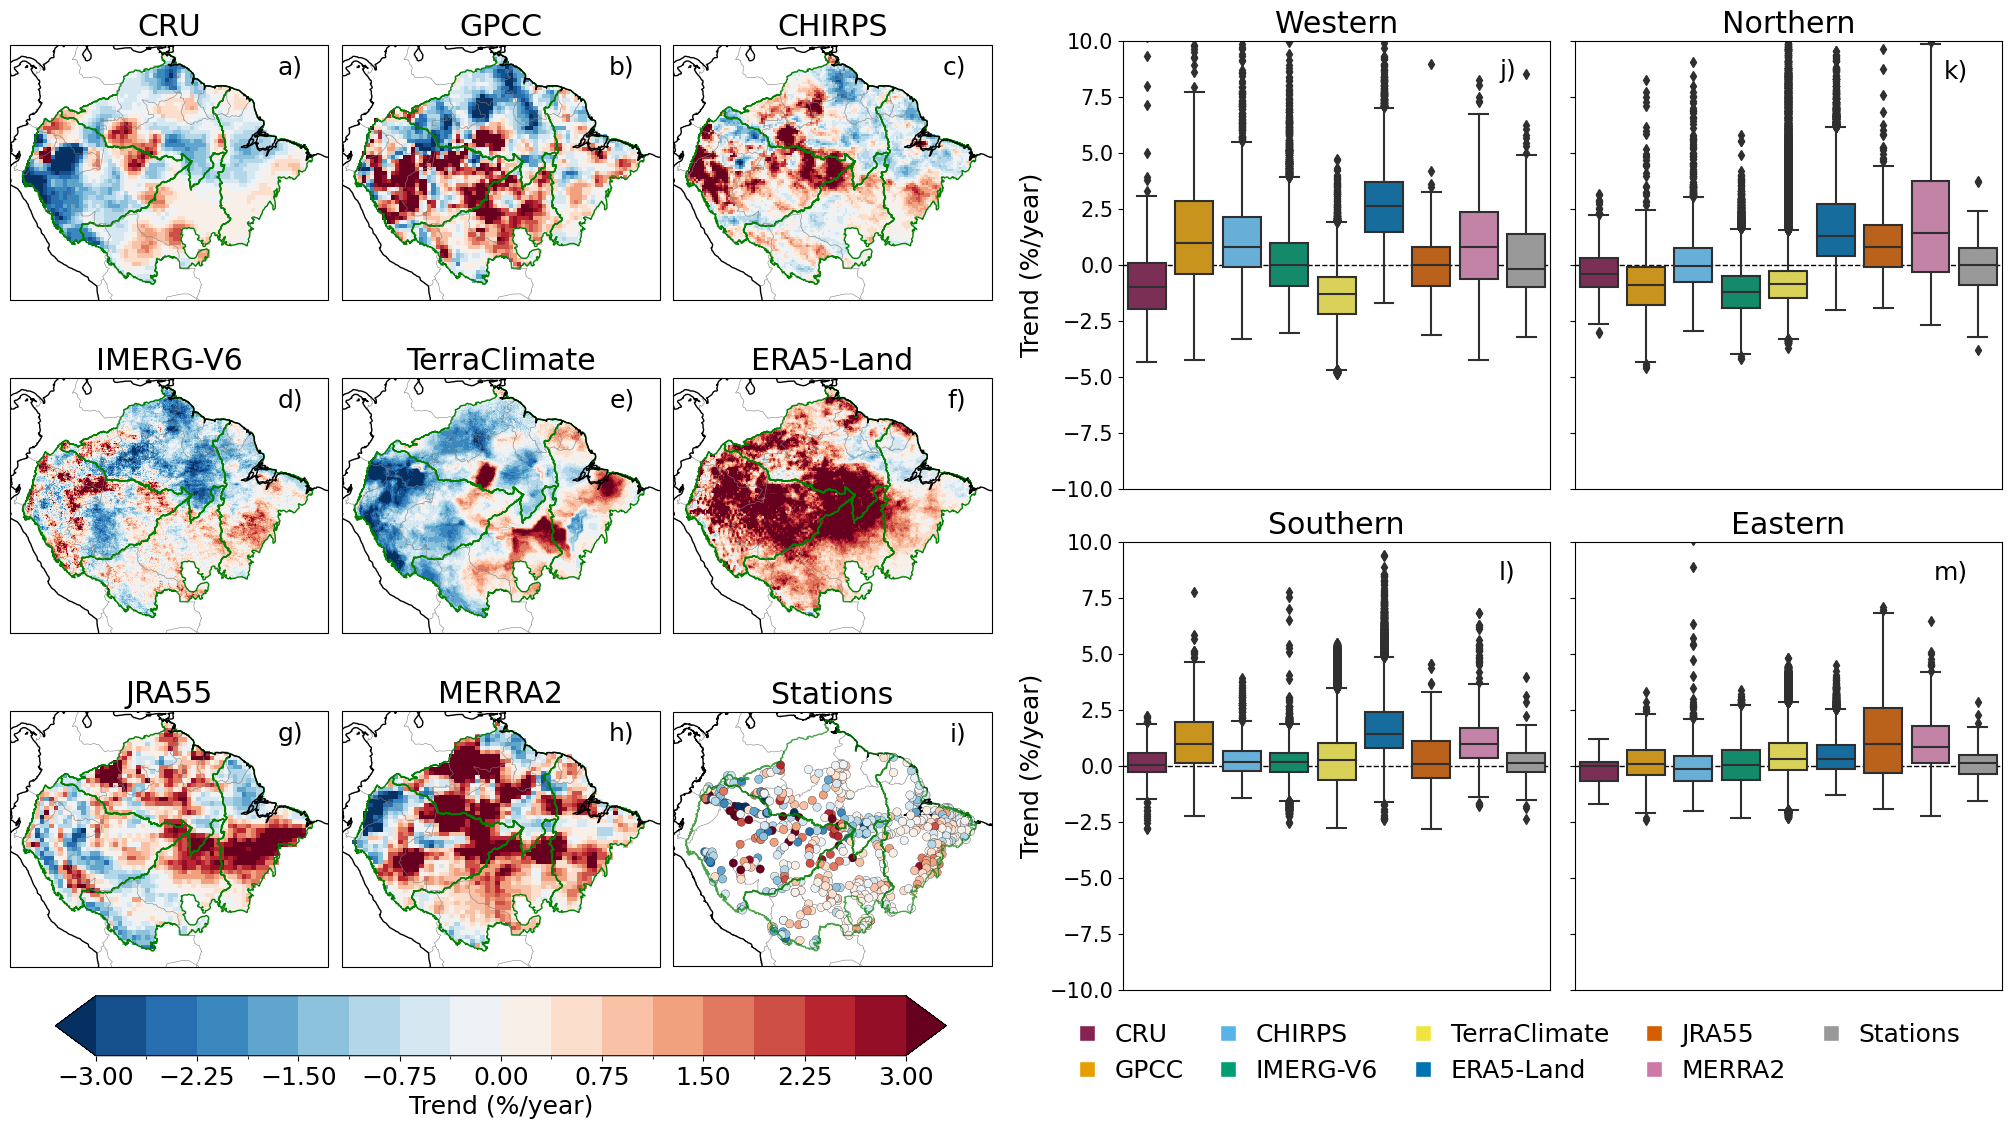

In [13]:
vmin = -3#40
vmax = 3#40
levels = 17
cmap =  mpl.cm.RdBu_r
extend_cbar = 'both'
var_plot = 'trend_ratio'#'slopes'
var_stat ='trend_ratio' #'slope_anual'
label_cbar = 'Trend (%/year)'#'MAP trend(mm/year/year)'
from Data.utils.datasets_plotting import plot_datasets33
letters_22 = ['j)', 'k)', 'l)', 'm)']

fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df
    axs_right[i].axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)

    sns.boxplot( y=var_plot, data=df[df.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(axis='y', which='both', labelsize=15)
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    #horizontal line in 0
    if i % 2 == 0:
        axs_right[i].set_ylabel(label_cbar)
    else:
        axs_right[i].set_ylabel('')
    axs_right[i].text(0.92,0.96,  letters_22[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
    axs_right[i].set_ylim(-10, 10)
plot_datasets33(subfigs[0], datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var_plot, var_stat, label_cbar)




#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)

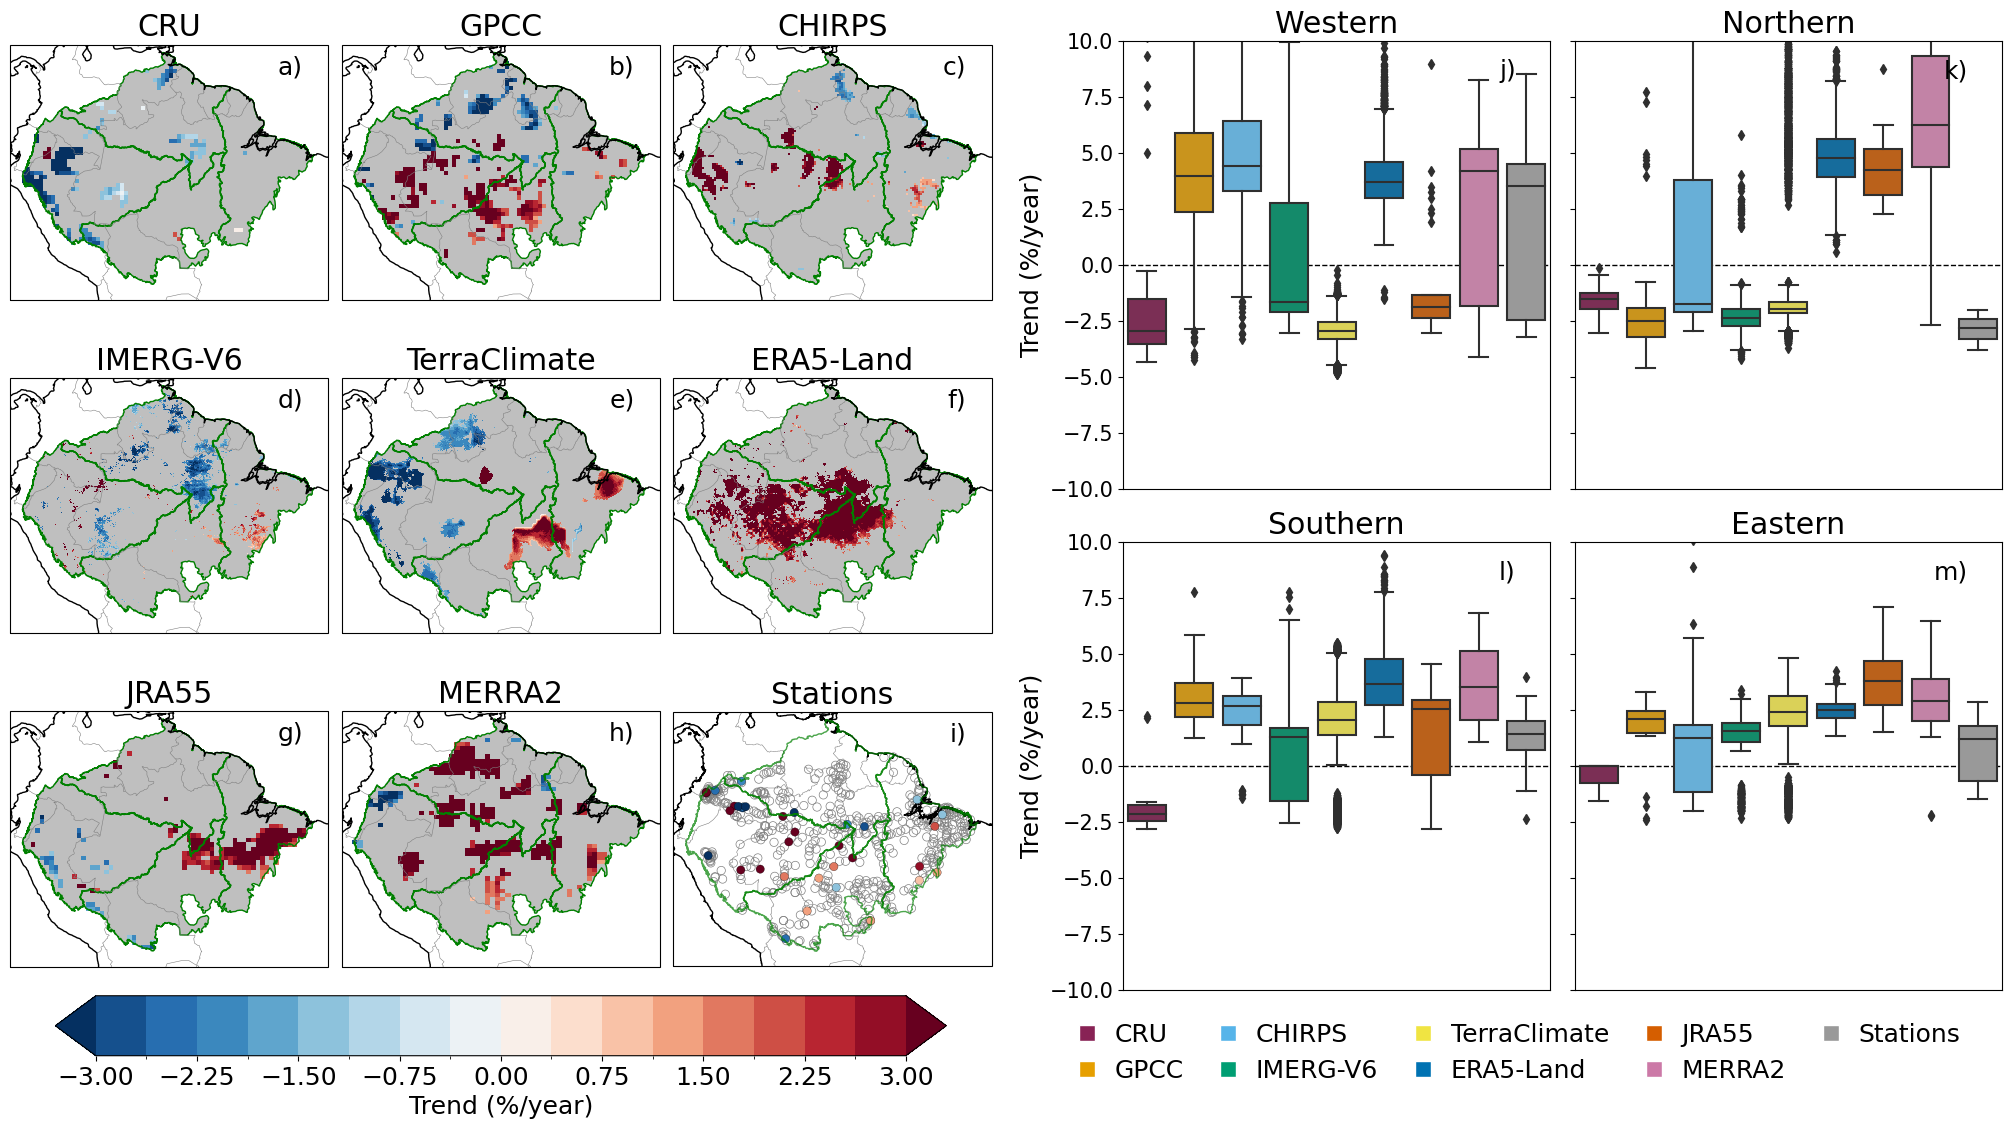

In [19]:
stattions_sig = stations[stations['p_'+ var] <= 0.05]
ds_dict_sig = {}
for i, name in enumerate(datasets_names):
    data = ds_dict[name]
    dss = data.where(data['p_values'] <= 0.05)
    ds_dict_sig[name] = dss

df_sig = df[df['p_values'] <= 0.05]


from Data.utils.datasets_plotting import plot_datasets33
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
letters_22 = ['j)', 'k)', 'l)', 'm)']
for i, region in enumerate(regions_list):
    #boxplot of df
    axs_right[i].axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)

    sns.boxplot( y=var_plot, data=df_sig[df_sig.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(axis='y', which='both', labelsize=15)
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    #horizontal line in 0
    if i % 2 == 0:
        axs_right[i].set_ylabel(label_cbar)
    else:
        axs_right[i].set_ylabel('')
    axs_right[i].text(0.92,0.96,  letters_22[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
    axs_right[i].set_ylim(-10, 10)
plot_datasets33(subfigs[0], datasets_names, ds_dict_sig, stattions_sig , regions, vmin, vmax, levels, cmap, extend_cbar, var_plot, var_stat, label_cbar)

for i, ax in enumerate(subfigs[0].axes):
    if i <= 8:
        if i == 8:
            stations[stations['p_' + var] >= 0.05].plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='grey',zorder=-10)
        else:    
            ax.add_geometries(shp_pan.geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='black', linewidth=0.1, zorder=-10, alpha=0.5)
    
    
   


#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)

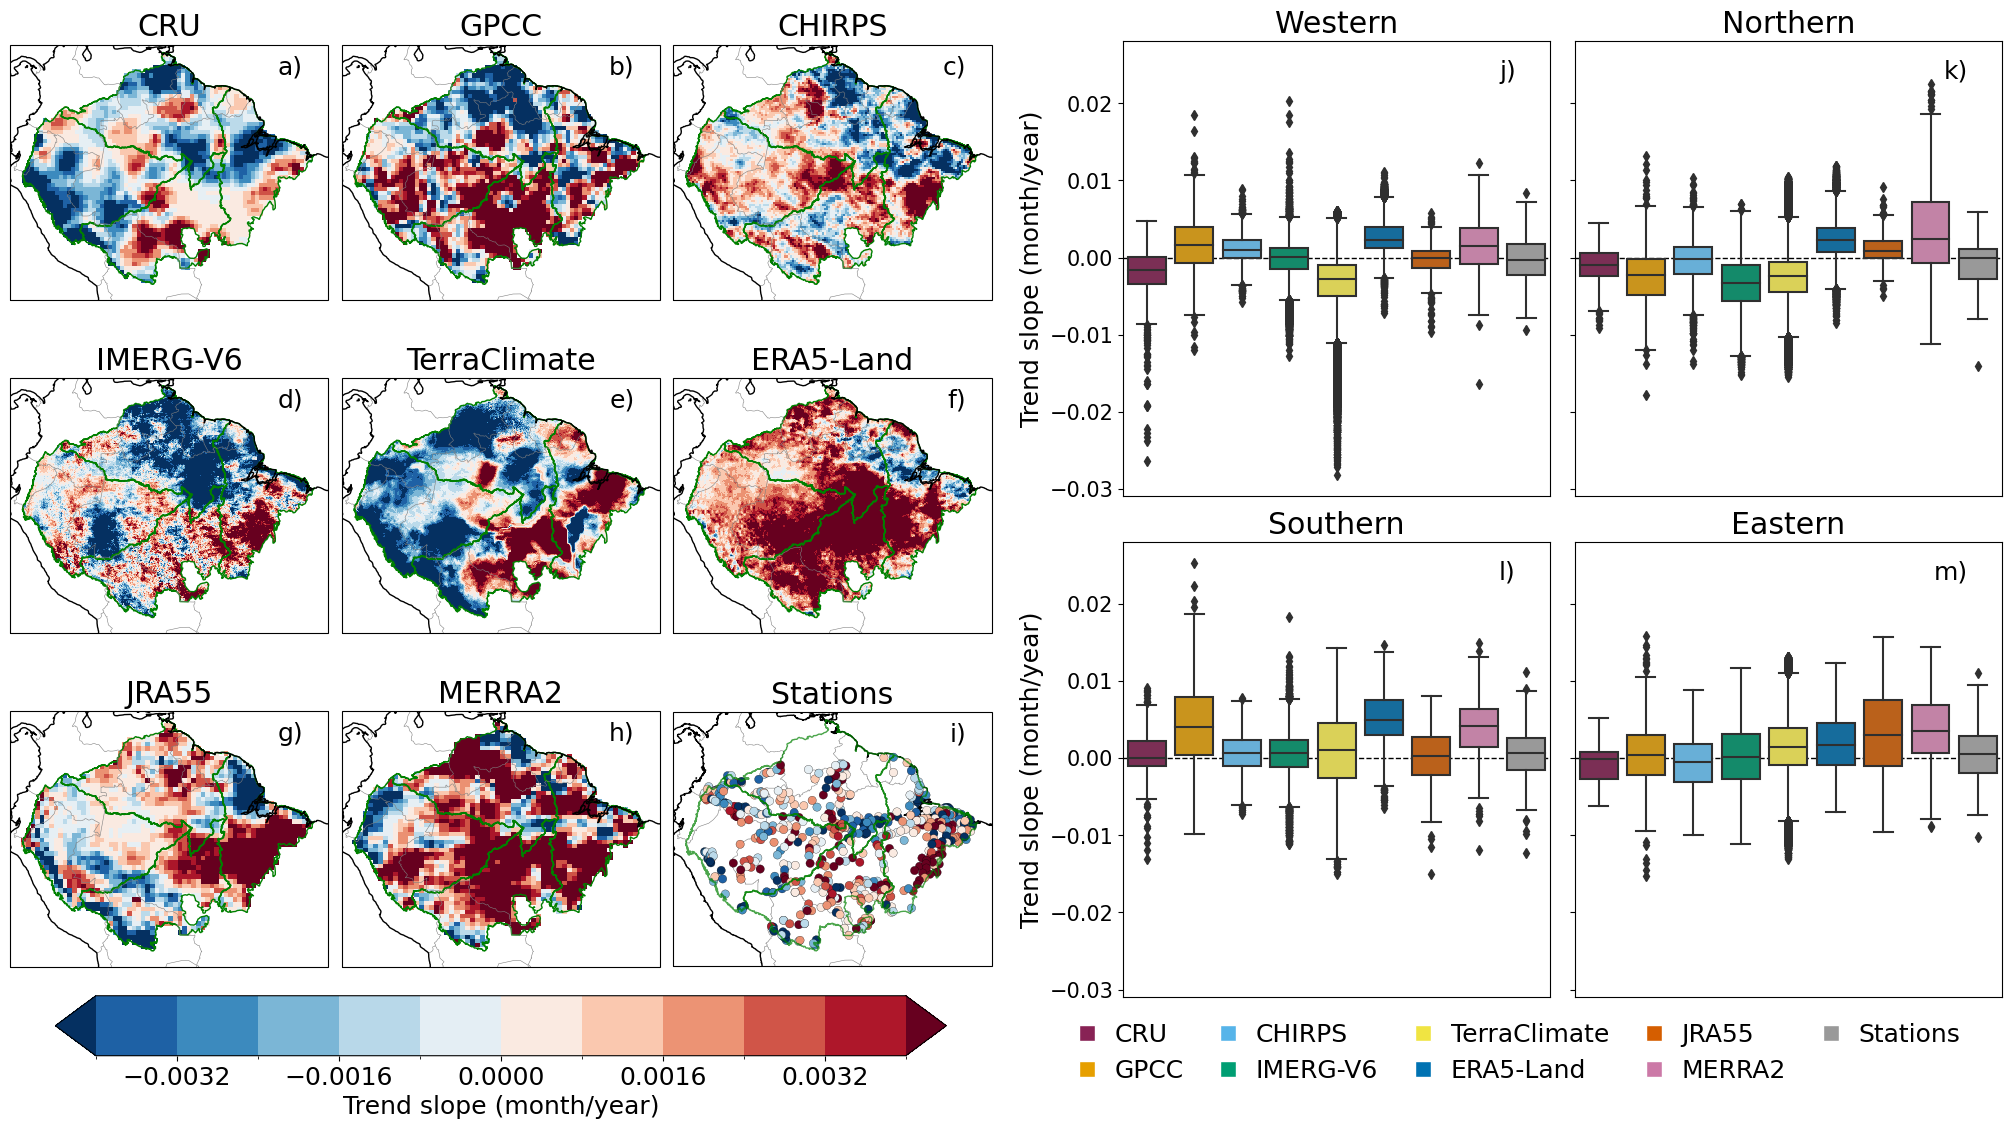

In [7]:
vmin = -0.004
vmax = 0.004
levels = 11
cmap =  mpl.cm.RdBu_r
extend_cbar = 'both'
var_plot = 'slopes'#'slopes'
var_stat ='slope_' + var  #'slope_anual'
label_cbar = 'Trend slope (month/year)'#'MAP trend(mm/year/year)'
from Data.utils.datasets_plotting import plot_datasets33
letters_22 = ['j)', 'k)', 'l)', 'm)']

fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df
    axs_right[i].axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)

    sns.boxplot( y=var_plot, data=df[df.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(axis='y', which='both', labelsize=15)
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    #horizontal line in 0
    if i % 2 == 0:
        axs_right[i].set_ylabel(label_cbar)
    else:
        axs_right[i].set_ylabel('')
    axs_right[i].text(0.92,0.96,  letters_22[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')

plot_datasets33(subfigs[0], datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var_plot, var_stat, label_cbar)




#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)


# point

In [8]:
stations['trend_ratio'] = stations['slope_'+ var] / stations['intercept_'+ var] * 100
data = stations[['geometry','slope_'+ var,'trend_ratio']].copy()
data = data.rename(columns={'slope_'+ var:'slopes'})
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])


In [9]:
metrics_dict = {}
for name in datasets_names:
    ds = ds_dict[name].copy()
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    for var_pp in ['trend_ratio', 'slopes']:

        # Step 3: Compute the mean value for each grid cell and each year
        grid_cells = data.groupby(['lat_bin', 'lon_bin'])[var_pp].mean().reset_index()
        # Step 4: Create an empty DataArray with NaN values
        empty_grid = np.full((len(ds_grid_lat), len(ds_grid_lon)), np.nan)
        # Step 5: Fill the DataArray with the computed mean values for each year
        for _, row in grid_cells.iterrows():
            #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
            lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
            lat_idx, lon_idx = int(lat_idx), int(lon_idx)
            empty_grid[lat_idx - 1, lon_idx - 1] = row[var_pp]
        # Step 6: Create an xarray DataArray from the result with the year dimension
        #year_coords = data['year'].unique()
        data_array = xr.DataArray(empty_grid,
                                    dims=('lat', 'lon'),
                                    coords={'lat': ds_grid_lat, 'lon': ds_grid_lon})
        # Calculate var_ppious metrics
        ds[var_pp + '_stat'] = data_array
    metrics_dict[name] = ds

In [10]:
df_compare = pd.DataFrame()
for name in datasets_names:
    df_comparef =  metrics_dict[name].to_dataframe().dropna().reset_index(drop=True)
    df_comparef['Dataset'] = name
    df_compare = df_compare.append(df_comparef)

df_compare = df_compare[['p_values', 'Region', 'Dataset','trend_ratio', 'trend_ratio_stat', 'slopes','slopes_stat']]
df_compare['Region'] = df_compare['Region'].replace(regions_replace)
#create significant column, if the row has pvalue less than 0.05 is significant
df_compare['significant'] = df_compare['p_values'] < 0.05
df_compare['significant'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)


C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_20592\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\A

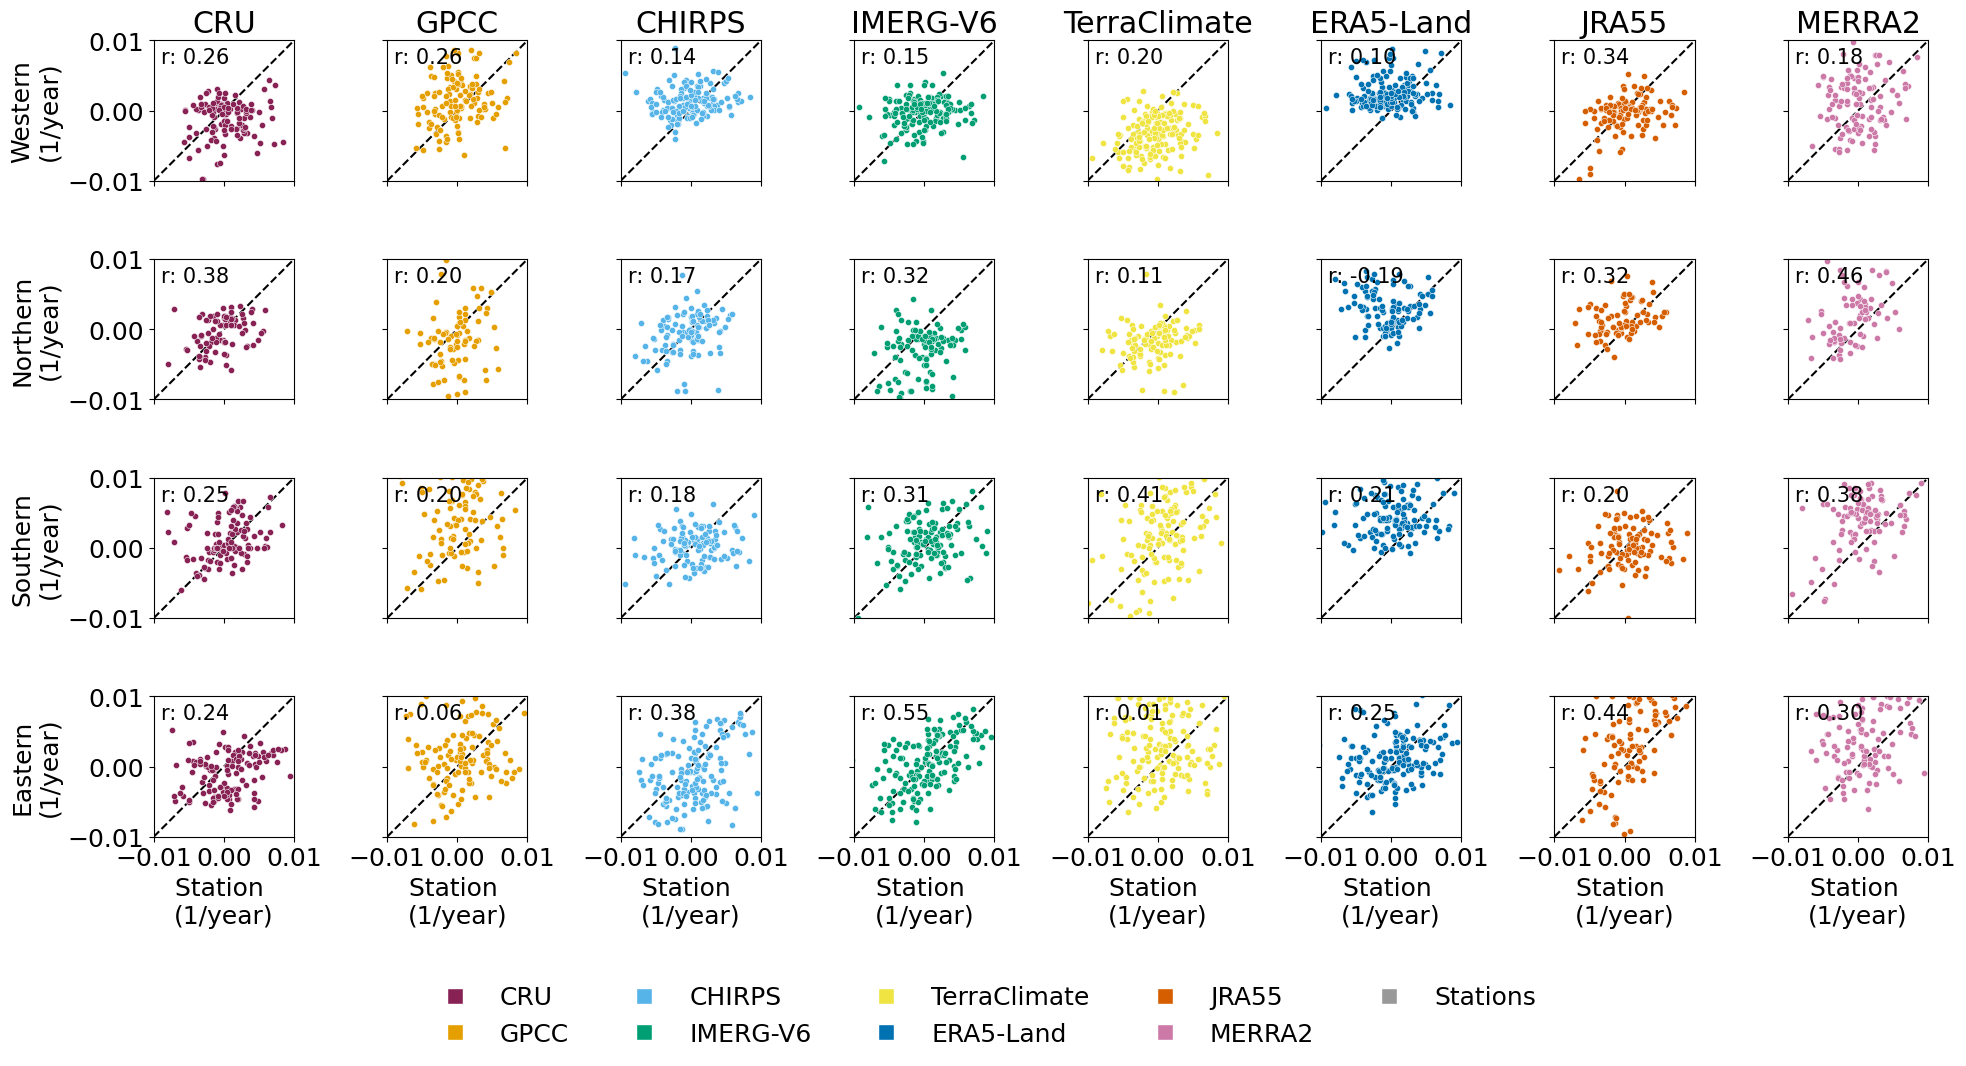

In [14]:
fig, axes = plt.subplots(4,8, figsize=(20,10), sharex=True, sharey=True)
limm = 0.01
for i, name in enumerate(datasets_names):
    df_ds = df_compare[df_compare['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='slopes_stat', y='slopes', ax=axes[j,i], s=20, color=wong[i], legend=False)
        
        axes[j,i].set_xlabel('Station \n(1/year)')
        axes[j,i].set_ylabel(region + '\n(1/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['slopes_stat'].corr(df_plot['slopes'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()

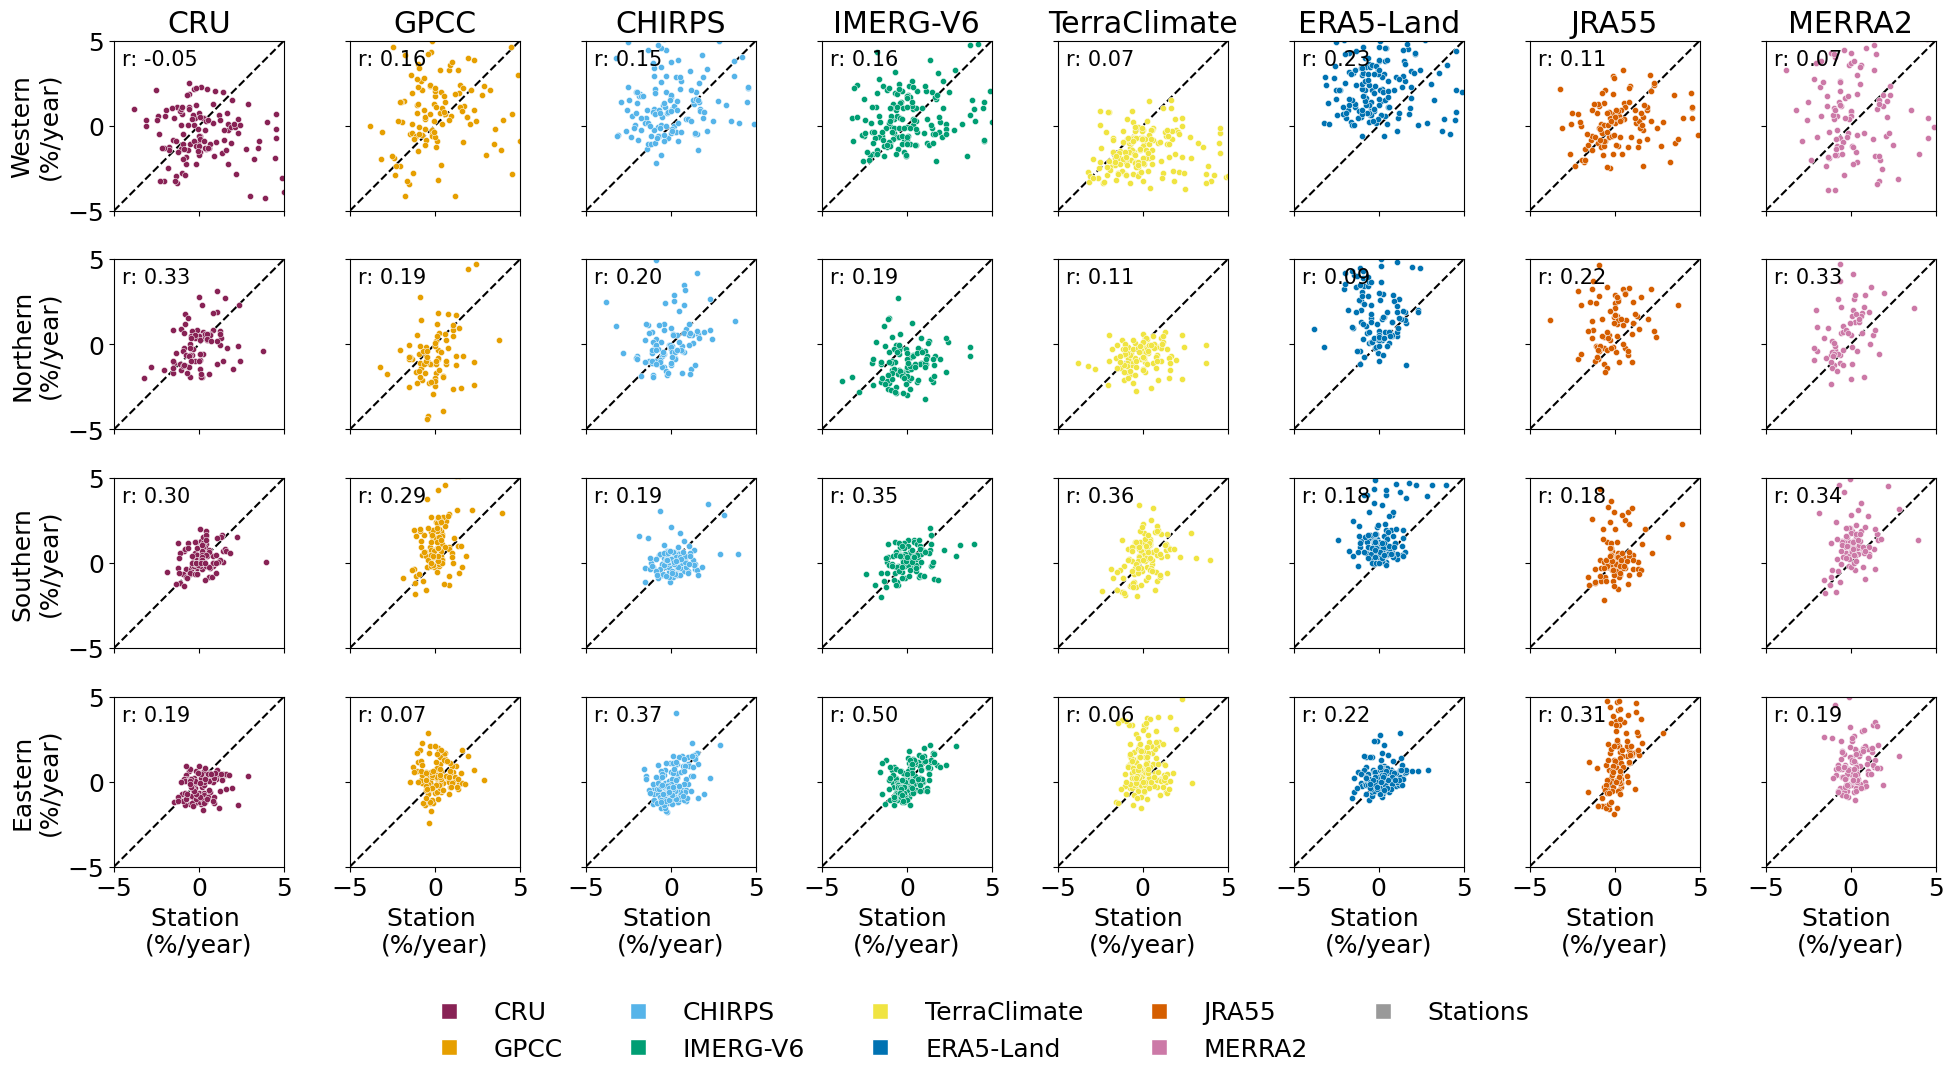

In [12]:
fig, axes = plt.subplots(4,8, figsize=(20,10), sharex=True, sharey=True)
limm = 5
for i, name in enumerate(datasets_names):
    df_ds = df_compare[df_compare['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='trend_ratio_stat', y='trend_ratio', ax=axes[j,i], s=20, color=wong[i], legend=False)
        
        axes[j,i].set_xlabel('Station \n(%/year)')
        axes[j,i].set_ylabel(region + '\n(%/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['trend_ratio_stat'].corr(df_plot['trend_ratio'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()